# Escenarios experimentales Internetworking 

# CNN ESCENARIO B
Presentado por: Jonathan Toapanta
Fecha: 08/03/2023


In [61]:
!pip install tensorflow-addons
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
# Load the data
url = 'https://raw.githubusercontent.com/jonathan-elian-toapanta/INTERNETWORKING/main/ESCENARIOS/ScenarioB.csv'
df = pd.read_csv(url)
df = pd.read_csv(url,low_memory=False)
dataframe = pd.read_csv(url,low_memory=False)

In [63]:
# Normalise the data
def dfNormalize(df):
    for feature_name in df.columns:
        df.loc[:,feature_name]= pd.to_numeric(df.loc[:,feature_name], errors='coerce').fillna(0)
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()   
        if (max_value - min_value) > 0:
            df.loc[:,feature_name] = (df.loc[:,feature_name] - min_value) / (max_value - min_value)
        else:
            df.loc[:,feature_name] = (df.loc[:,feature_name]- min_value)    
    return df

In [64]:
# Split the data into train and test sets
y = df['label']
label_map = {'AUDIO': 0, 'BROWSING': 1, 'CHAT': 2, 'FILE-TRANSFER' : 3, 'MAIL' : 4, 'P2P' : 5, 'VIDEO' : 6, 'VOIP' : 7}
change_labels = lambda x: label_map[x] if x in label_map else -1
y = df['label'].apply(change_labels)

In [65]:
X = df.iloc[:, 4:-1]
X = dfNormalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [66]:
# Reshape the data for Conv1D
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))


In [67]:
# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [68]:
# Define the model
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation='softmax')
])

In [69]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score


In [70]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall(), F1Score(num_classes=8, average='macro')])


In [71]:
# Set up EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)


In [72]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/10
202/202 [==============================] - 4s 11ms/step - loss: 1.6090 - accuracy: 0.4093 - precision_2: 0.5670 - recall_2: 0.1368 - f1_score: 0.1761 - val_loss: 1.3890 - val_accuracy: 0.4723 - val_precision_2: 0.7912 - val_recall_2: 0.2356 - val_f1_score: 0.1782
Epoch 2/10
202/202 [==============================] - 3s 14ms/step - loss: 1.3965 - accuracy: 0.4707 - precision_2: 0.6467 - recall_2: 0.2367 - f1_score: 0.2360 - val_loss: 1.2742 - val_accuracy: 0.5022 - val_precision_2: 0.6936 - val_recall_2: 0.3151 - val_f1_score: 0.2532
Epoch 3/10
202/202 [==============================] - 4s 17ms/step - loss: 1.3009 - accuracy: 0.5144 - precision_2: 0.7019 - recall_2: 0.2982 - f1_score: 0.2991 - val_loss: 1.2910 - val_accuracy: 0.5364 - val_precision_2: 0.6393 - val_recall_2: 0.3580 - val_f1_score: 0.3092
Epoch 4/10
202/202 [==============================] - 3s 14ms/step - loss: 1.2112 - accuracy: 0.5764 - precision_2: 0.7603 - recall_2: 0.3436 - f1_score: 0.3783 - val_loss: 1.

In [73]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(X_test, y_test)


51/51 [==============================] - 0s 5ms/step - loss: 0.8728 - accuracy: 0.7073 - precision_2: 0.7949 - recall_2: 0.5948 - f1_score: 0.5075


In [74]:
# Print the test set metrics
print('Test set metrics:')
print('  Loss:     {:.3f}'.format(test_loss))
print('  Accuracy: {:.3f}'.format(test_accuracy))
print('  Precision:{:.3f}'.format(test_precision))
print('  Recall:   {:.3f}'.format(test_recall))
print('  F1 Score: {:.3f}'.format(test_f1))


Test set metrics:
  Loss:     0.873
  Accuracy: 0.707
  Precision:0.795
  Recall:   0.595
  F1 Score: 0.508


In [75]:
# Plot the ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [76]:
y_pred = model.predict(X_test)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


51/51 [==============================] - 0s 3ms/step


In [77]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


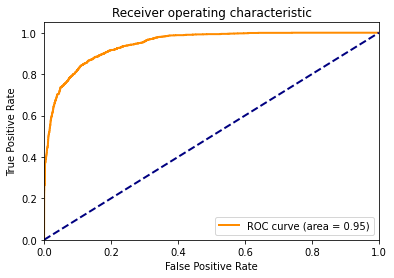

In [78]:
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# RANDOM FOREST

In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical


In [114]:
# Load the data
url = 'https://raw.githubusercontent.com/jonathan-elian-toapanta/INTERNETWORKING/main/ESCENARIOS/ScenarioB.csv'
df = pd.read_csv(url)
df= pd.read_csv(url,low_memory=False)
dataframe= pd.read_csv(url,low_memory=False)


In [115]:
# Normalise the data
def dfNormalize(df):
    for feature_name in df.columns:
        df.loc[:,feature_name]= pd.to_numeric(df.loc[:,feature_name], errors='coerce').fillna(0)
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()   
        if (max_value - min_value) > 0:
            df.loc[:,feature_name] = (df.loc[:,feature_name] - min_value) / (max_value - min_value)
        else:
            df.loc[:,feature_name] = (df.loc[:,feature_name]- min_value)    
    return df


In [116]:
# Split the data into train and test sets
y = df['label']
label_map = {'AUDIO': 0, 'BROWSING': 1, 'CHAT': 2, 'FILE-TRANSFER' : 3, 'MAIL' : 4, 'P2P' : 5, 'VIDEO' : 6, 'VOIP' : 7}
change_labels = lambda x: label_map[x] if x in label_map else -1
y = df['label'].apply(change_labels)


In [117]:
X = df.iloc[:, 4:-1]
X = dfNormalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [118]:
# Create a Random Forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100, random_state=42)


In [119]:
# Perform cross validation with 5 folds
scores = cross_val_score(rfc, X_train, y_train, cv=8)


In [120]:
# Train the model on the training data
rfc.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [121]:
# Make predictions on the test data
y_pred = rfc.predict(X_test)


In [122]:
# Calculate the accuracy, precision, recall, and f1-score of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


In [123]:
# Print the results
print("Cross-validation scores:", scores)
print("Average cross-validation score:", np.mean(scores))
print("Test accuracy:", accuracy)
print("Test precision:", precision)
print("Test recall:", recall)
print("Test F1-score:", f1)

Cross-validation scores: [0.82111801 0.85093168 0.82732919 0.83457711 0.85447761 0.8420398
 0.82587065 0.83208955]
Average cross-validation score: 0.8360542010444671
Test accuracy: 0.8384089496581728
Test precision: 0.8384859582948729
Test recall: 0.8384089496581728
Test F1-score: 0.8339501085075295


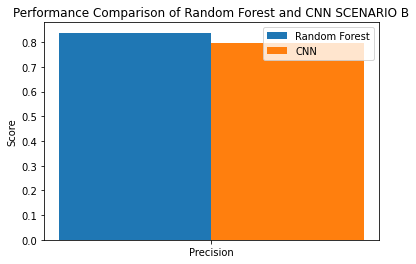

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics and their scores
metrics = ['Precision']
rf_scores = [precision]
cnn_scores = [test_precision]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars
bar_positions_rf = np.arange(len(metrics))
bar_positions_cnn = bar_positions_rf + bar_width

# Create the bar plots
plt.bar(bar_positions_rf, rf_scores, width=bar_width, label='Random Forest')
plt.bar(bar_positions_cnn, cnn_scores, width=bar_width, label='CNN')

# Add labels and title
plt.xticks(bar_positions_rf + bar_width / 2, metrics)
plt.ylabel('Score')
plt.title('Performance Comparison of Random Forest and CNN SCENARIO B')

# Add legend and show the plot
plt.legend()
plt.show()

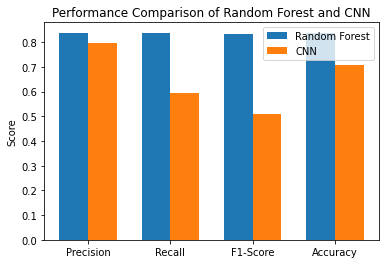

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics and their scores
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
rf_scores = [precision, recall, f1, accuracy]
cnn_scores = [test_precision, test_recall, test_f1, test_accuracy]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars
bar_positions_rf = np.arange(len(metrics))
bar_positions_cnn = bar_positions_rf + bar_width



# Create the bar plots
plt.bar(bar_positions_rf, rf_scores, width=bar_width, label='Random Forest')
plt.bar(bar_positions_cnn, cnn_scores, width=bar_width, label='CNN')

# Add labels and title
plt.xticks(bar_positions_rf + bar_width / 2, metrics)
plt.ylabel('Score')
plt.title('Performance Comparison of Random Forest and CNN')

# Add legend and show the plot
plt.legend()
plt.show()